In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.sparse.linalg import eigsh


In [4]:

# Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def kron_n(ops):
    return reduce(np.kron, ops)

def tfim_hamiltonian(n, J=1.0, h=1.0, eps=0):
    # \mathcal{H}_{\text{TFIM}} = -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n - 1):
        ops = [I]*n
        ops[i], ops[i+1] = Z, Z
        H -= J * kron_n(ops)
    for i in range(n):
        ops = [I]*n
        ops[i] = X
        H -= h * kron_n(ops)

        # add small epsilon bias to break degeneracy
        #ops = [I]*n
        #ops[i] = Z
        #H -= eps * kron_n(ops)

    return H

def xxz_hamiltonian(n, Delta=1.0, eps=0):
    # \mathcal{H}_{\text{XXZ}} = \sum_{\langle i,j \rangle} \left[ \Delta \left(\sigma_i^x \sigma_j^x + \sigma_i^y \sigma_j^y \right) + \sigma_i^z \sigma_j^z \right]
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n - 1):
        ops = [I]*n
        ops[i], ops[i+1] = X, X
        H += Delta * kron_n(ops)

        ops = [I]*n
        ops[i], ops[i+1] = Y, Y
        H += Delta * kron_n(ops)

        ops = [I]*n
        ops[i], ops[i+1] = Z, Z
        H += kron_n(ops)
    # add small epsilon bias to break degeneracy
    for i in range(n):
        ops = [I]*n
        ops[i] = Z
        H -= eps * kron_n(ops)
        
    return H

def marshall_U(n):
    """Construct the Marshall sign rule unitary for n spins on a 1D chain."""
    ops = [I] * n
    for i in range(n):
        if i % 2 == 0:  # flip sign on every second site
            ops[i] = Z
    U = kron_n(ops)
    return U

# Example
n = 3
H_tfim = tfim_hamiltonian(n)
H_xxz = xxz_hamiltonian(n)


In [5]:
# get ground state via lanczos

def ground_state(H, use_lanczos=False):
    if use_lanczos:
        vals, vecs = eigsh(H, k=1, which='SA')  # using lanczos to get smallest eigenvalue
    else:
        vals, vecs = np.linalg.eigh(H)  # full diagonalization
    return vals[0], vecs[:, 0]

In [6]:
n=6
H = xxz_hamiltonian(n)
U = marshall_U(n)
# H = U @ H @ U  # transform to stoquastic form
E0, psi0 = ground_state(H)
# E0, psi0 = ground_state(H)
print("Ground state energy:", E0)

Ground state energy: -9.9743085355517


In [7]:
E0_, psi0_ = ground_state(H, use_lanczos=True)
psi0_m = psi0_.copy()
# set imag part to zero
psi0_m.imag = 0.0

print("Ground state energy (lanczos):", E0_)
np.linalg.norm(H@psi0_/E0_ -psi0_)  # should be small
print("overlap between lanczos and full diag:", np.abs(np.vdot(psi0_m, psi0)))
print("energy difference:", np.abs(E0 - E0_))


Ground state energy (lanczos): -9.974308535551737
overlap between lanczos and full diag: 0.9123743412003127
energy difference: 3.730349362740526e-14


In [8]:
np.linalg.norm(H@psi0/E0 -psi0)  # should be small

6.487635857810329e-16

In [9]:
psi0m = psi0.copy()
# set imag part to zero
psi0m.imag = 0.0

np.linalg.norm(H@psi0m/E0 - psi0m)  # should be small

6.481695906610466e-16

In [10]:
psi0

array([ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        5.55111512e-17+0.j,  0.00000000e+00+0.j, -2.76222877e-17+0.j,
        6.05147616e-18+0.j,  9.36044902e-03+0.j,  0.00000000e+00+0.j,
        5.55111512e-17+0.j, -5.55111512e-17+0.j, -6.07226768e-02+0.j,
        0.00000000e+00+0.j,  1.31555785e-01+0.j, -8.01935569e-02+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j, -1.56797881e-17+0.j,
       -5.91977739e-18+0.j,  1.31555785e-01+0.j,  2.40615311e-17+0.j,
       -4.49394867e-01+0.j,  3.08478633e-01+0.j,  5.57599265e-19+0.j,
       -4.98332858e-18+0.j,  2.37645525e-01+0.j, -3.08478633e-01+0.j,
       -1.30196128e-19+0.j,  8.01935569e-02+0.j,  2.88762844e-20+0.j,
       -3.68721008e-21+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        1.89991998e-18+0.j,  2.73371547e-18+0.j, -8.01935569e-02+0.j,
       -6.81496947e-18+0.j,  3.08478633e-01+0.j, -2.37645525e-01+0.j,
       -1.01319844e-19+0.j,  2.78441037e-18+0.j, -3.08478633e-01+0.j,
        4.49394867e-

In [11]:
from functools import lru_cache
@lru_cache(maxsize=None)
def transverse_magnetization_op(n):
    """Construct the transverse magnetization operator for n spins.
    XI..I + IX..I + ... + I..IX"""
    Mx = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n):
        ops = [I]*n
        ops[i] = X
        Mx += kron_n(ops)
    return Mx

@lru_cache(maxsize=None)
def magnetization_op(n):
    """Construct the magnetization operator for n spins.
    ZI..I + IZ..I + ... + I..IZ"""
    Mz = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n):
        ops = [I]*n
        ops[i] = Z
        Mz += kron_n(ops)
    return Mz

In [12]:
from tqdm import tqdm
n = 6
hs_tfim = np.linspace(0.001, 2.0, 30)
ground_states_tfim = []
gs_energies_tfim = []
gs_angles_tfim = []
gs_tmag_tfim = []
gs_mag_tfim = []

for h in tqdm(hs_tfim):
    H = tfim_hamiltonian(n=n, h=h, eps=1e-3)
    E0, psi0 = ground_state(H, use_lanczos=True)
    ground_states_tfim.append(psi0)
    gs_energies_tfim.append(E0)
    angles = np.angle(psi0)
    # normalize angle so that first entry is zero
    angles -= angles[0]
    gs_angles_tfim.append(angles)
    Mx = transverse_magnetization_op(n)
    tmag = np.vdot(psi0, Mx @ psi0).real
    gs_tmag_tfim.append(tmag)

    Mz = magnetization_op(n)
    smag = np.vdot(psi0, Mz @ psi0).real
    gs_mag_tfim.append(smag)

100%|██████████| 30/30 [00:00<00:00, 191.55it/s]


Text(0, 0.5, 'Ground State Energy')

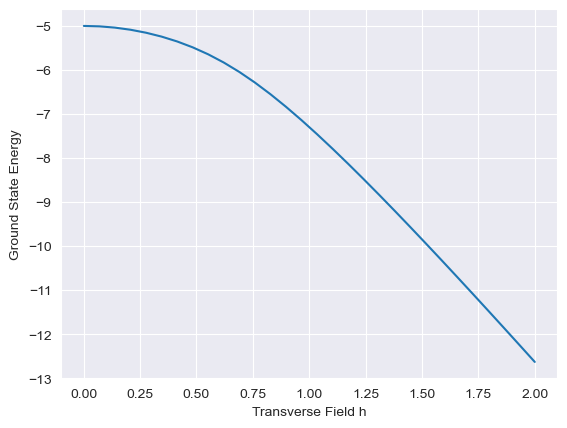

In [13]:
fig = plt.figure()
plt.plot(hs_tfim, gs_energies_tfim, label='Ground State Energy')
plt.xlabel('Transverse Field h')
plt.ylabel('Ground State Energy')

Text(0, 0.5, 'Transverse Magnetization')

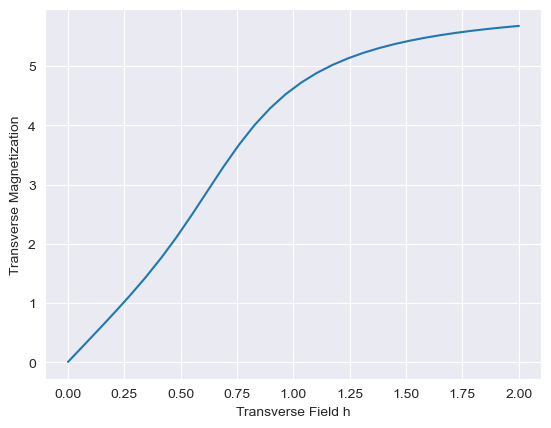

In [14]:
fig = plt.figure()
plt.plot(hs_tfim, gs_tmag_tfim, label='Transverse Magnetization')
plt.xlabel('Transverse Field h')
plt.ylabel('Transverse Magnetization')

Text(0, 0.5, 'Magnetization')

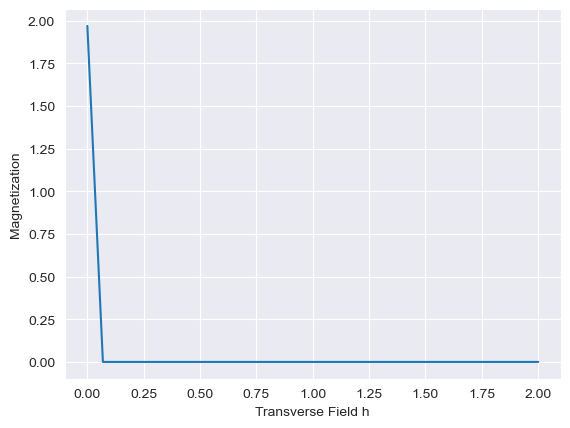

In [15]:
fig = plt.figure()
plt.plot(hs_tfim, gs_mag_tfim, label='Magnetization')
plt.xlabel('Transverse Field h')
plt.ylabel('Magnetization')

Text(0, 0.5, 'Ground State Angle')

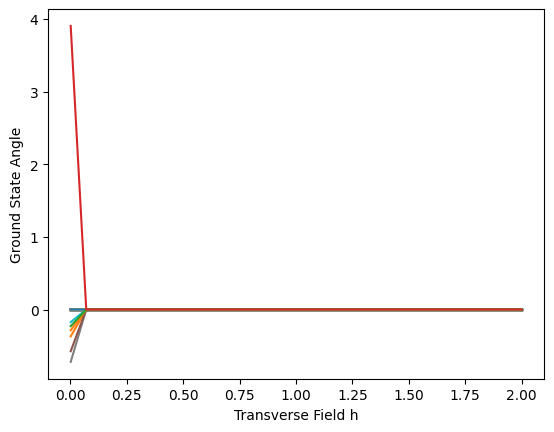

In [14]:
fig = plt.figure()
plt.plot(hs_tfim, gs_angles_tfim, label='Ground State Angle')
plt.xlabel('Transverse Field h')
plt.ylabel('Ground State Angle')

In [15]:
def Czz_NN_op(n, pbc=False):
    """Nearest-neighbor correlation operator C_zz^NN."""
    C = np.zeros((2**n, 2**n), complex)
    L = n if pbc else n - 1
    for i in range(L):
        j = (i + 1) % n
        ops = [I]*n
        ops[i], ops[j] = Z, Z
        C += kron_n(ops)
    norm = L if pbc else (n - 1)
    return C / norm

def Cxx_NN_op(n, pbc=False):
    """Nearest-neighbor correlation operator C_xx^NN."""
    C = np.zeros((2**n, 2**n), complex)
    L = n if pbc else n - 1
    for i in range(L):
        j = (i + 1) % n
        ops = [I]*n
        ops[i], ops[j] = X, X
        C += kron_n(ops)
    norm = L if pbc else (n - 1)
    return C / norm

In [16]:
from tqdm import tqdm
n = 6
hs_xxz = np.linspace(0.001, 6.0, 30)
ground_states_xxz = []
gs_energies_xxz = []
gs_angles_xxz = []
gs_tmag_xxz = []
gs_mag_xxz = []
gs_czz = []
gs_cxx = []

for h in tqdm(hs_xxz):
    H = xxz_hamiltonian(n=n, Delta=h, eps=1e-3)
    U = marshall_U(n)
    H = U @ H @ U  # transform to stoquastic form
    E0, psi0 = ground_state(H, use_lanczos=False)
    ground_states_xxz.append(psi0)
    gs_energies_xxz.append(E0)
    angles = np.angle(psi0)
    # normalize angle so that first entry is zero
    angles -= angles[0]
    gs_angles_xxz.append(angles)
    Mx = transverse_magnetization_op(n)
    tmag = np.vdot(psi0, Mx @ psi0).real
    gs_tmag_xxz.append(tmag)
    
    Czz = Czz_NN_op(n)
    gs_czz.append(np.vdot(psi0, Czz @ psi0).real)
    Cxx = Cxx_NN_op(n)
    gs_cxx.append(np.vdot(psi0, Cxx @ psi0).real)

    Mz = magnetization_op(n)
    smag = np.vdot(psi0, Mz @ psi0).real
    gs_mag_xxz.append(smag)

100%|██████████| 30/30 [00:00<00:00, 266.33it/s]


Text(0, 0.5, 'Ground State Energy')

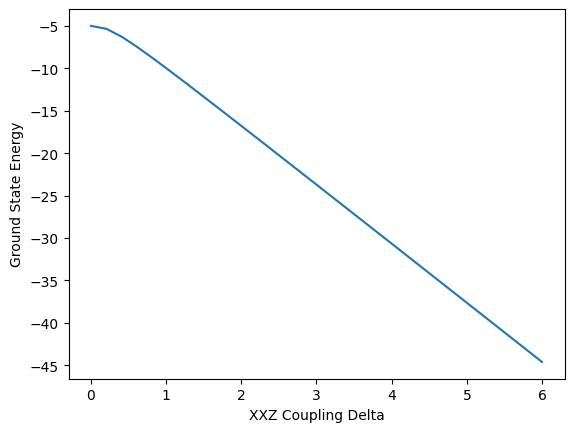

In [17]:
fig = plt.figure()
plt.plot(hs_xxz, gs_energies_xxz, label='Ground State Energy')
plt.xlabel('XXZ Coupling Delta')
plt.ylabel('Ground State Energy')

Text(0, 0.5, 'Transverse Magnetization')

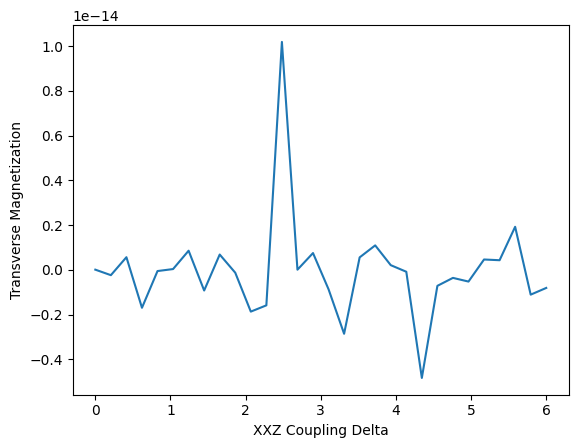

In [18]:
fig = plt.figure()
plt.plot(hs_xxz, gs_tmag_xxz, label='Transverse Magnetization')
plt.xlabel('XXZ Coupling Delta')
plt.ylabel('Transverse Magnetization')

Text(0, 0.5, 'Magnetization')

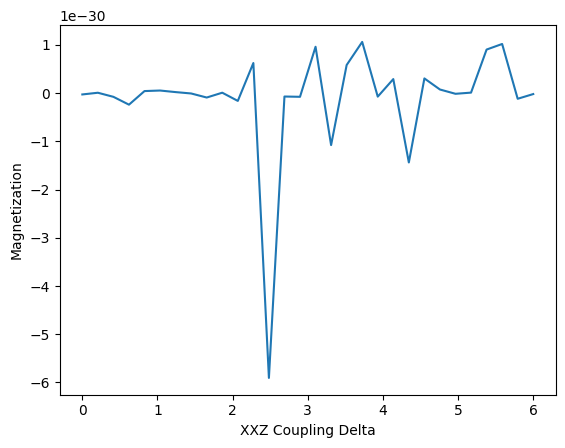

In [19]:
fig = plt.figure()
plt.plot(hs_xxz, gs_mag_xxz, label='Magnetization')
plt.xlabel('XXZ Coupling Delta')
plt.ylabel('Magnetization')

Text(0, 0.5, 'Ground State Czz')

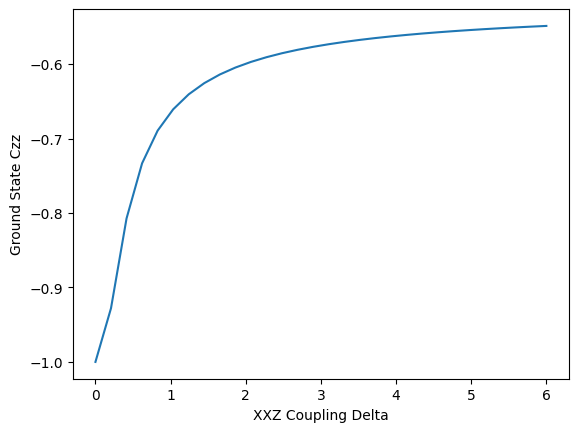

In [20]:
fig = plt.figure()
plt.plot(hs_xxz, gs_czz, label='Ground State Czz')
plt.xlabel('XXZ Coupling Delta')
plt.ylabel('Ground State Czz')

Text(0, 0.5, 'Ground State Cxx')

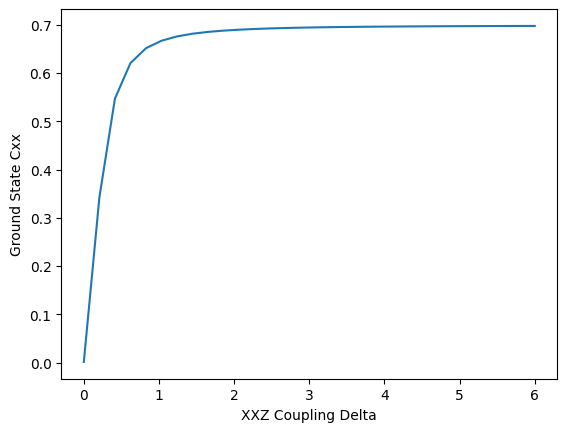

In [21]:
fig = plt.figure()
plt.plot(hs_xxz, gs_cxx, label='Ground State Cxx')
plt.xlabel('XXZ Coupling Delta')
plt.ylabel('Ground State Cxx')

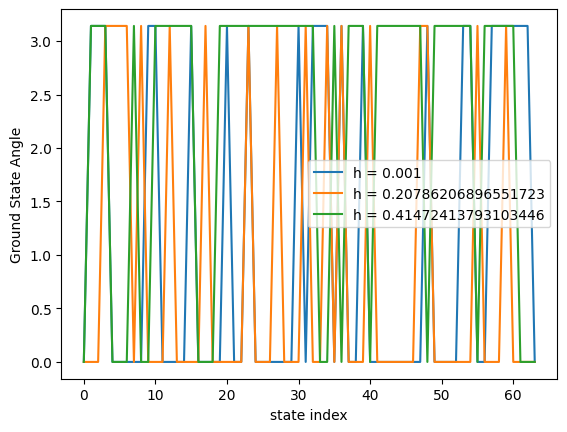

In [22]:
fig = plt.figure()
for ii, angle in enumerate(gs_angles_xxz[:3]):
    plt.plot(angle, label=f'h = {hs_xxz[ii]}')
plt.xlabel('state index')
plt.ylabel('Ground State Angle')
plt.legend()

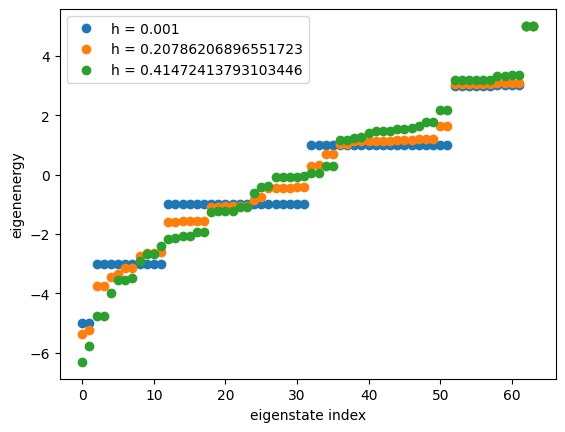

In [23]:
plt.figure()
for h in hs_xxz[:3]:
    H = xxz_hamiltonian(n=n, Delta=h, eps=1e-3)
    ev, evec = np.linalg.eigh(H)

    plt.plot(ev, 'o', label=f'h = {h}')
plt.xlabel('eigenstate index')
plt.ylabel('eigenenergy')
plt.legend()